# ClimateMARGO.jl tutorial

The following schematic shows the full formulation of the MARGO model. No-policy baseline emissions $q(t)$ are prescribed, leading to changing greenhouse gas (CO$_{2e}$) concentrations, radiative forcing, temperatures, and climate damages. Emissions can be decreased by **M**itigation, concentrations can be decreased by carbon dioxide **R**emoval, forcing can be decreased by solar **G**eo-engineering, and the "adapted" temperature that leads to climate damages can be reduced by **A**dapting to the changed climate.
<img src="../../docs/src/MARGO_schematic.png" alt="drawing" width="60%" style="float:left"/>

### Import software

In [1]:
using ClimateMARGO

┌ Info: Precompiling ClimateMARGO [39978bfe-ac6a-4fbe-9981-75100ee30276]
└ @ Base loading.jl:1273


## Model parameters

Here, we run through the full construction of the model with its default parameter values. Alternatively, the default configuration can be instantiated by simply calling 

```julia
model = ClimateModel()
```

#### Temporal grid
First, we need to set up a time-frame for our experiment. Let's begin in the present (2020) and consider out to 2200, with a 5-year timestep for computational efficiency.

In [2]:
# Temporal grid
present_year = 2020. # [yr]
final_year = 2200. # [yr]
dt = 5. # [yr]
t = Array(present_year:dt:final_year); # [yr]

# For unit conversions later
sec_per_year = (365. * 24. * 60. * 60.); # [s/yr]

#### Model physics

Next, we determine some of the physical model parameters that govern the strength of the greenhouse effect $a$, the strength of climate feedbacks $B$, the heat uptake rate $\kappa$ and the deep ocean heat capacity $C_{D}$. These default values are taken from [Geoffroy et al. 2013](https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-12-00195.1).

In [3]:
# Two-layer EBM
a = (6.9/2.)/log(2.); # F4xCO2/2 / log(2) [W m^-2]
B = 1.13 * sec_per_year; # Feedback parameter [J yr^-1 m^-2 K^-1]
Cd = 106 * sec_per_year; # Deep ocean heat capacity [J m^-2 K^-1]
κ = 0.73 * sec_per_year; # Heat exchange coefficient [J yr^-1 m^2 K^-1]

# Initial condition: present-day temperature, relative to pre-industrial
δT_init = 1.1; # [degC] Berkeley Earth Surface Temperature (Rohde 2013)

These physical parameters can be used to diagnose the climate sensitivity to a doubling of CO$_{2}$ ($ECS$) and the deep ocean timescale $\tau_{D}$.

In [4]:
# Physical diagnostics
FCO₂_2x = a*log(2) # Forcing due to doubling CO2 (Geoffrey 2013)

ECS = (FCO₂_2x*sec_per_year)/B # [degC]
τd = (Cd/B) * (B+κ)/κ # [yr]

print("ECS = ", round(ECS,digits=1) ,"ºC, τD = ", round(τd), " years")

ECS = 3.1ºC, τD = 239.0 years

The carbon cycle in MARGO is extremely simple. Half of the CO$_{2e}$ emitted into the atmosphere is immediately taken up by the biosphere and oceans.

In [5]:
# Carbon model
CO₂_init = 460. # [ppm]
r = 0.5; # [1] fraction of emissions remaining after biosphere and ocean uptake (Solomon 2009)

These parameters define the physical model.

In [6]:
Phys = Physics(CO₂_init, δT_init, a, B, Cd, κ, r);

#### Economic parameters

Economic growth in MARGO (in terms of Gross World Product, GWP) is exogenous $E(t) = E_{0} (1 + \gamma)^{(t-t_{0})}$ and is entirely determined by the growth rate $\gamma$. By default, we set $\gamma = 2\%$.

In [7]:
# Exogenous GWP
GWP0 = 100. # global world product at t0 [10^12$ yr^-1]
γ = 0.02 # economic growth rate
GWP(t) = GWP0 * (1. + γ).^(t .- t[1]); # global world product [10^12$ yr^-1]

Economic damages, expressed as a fraction of the instantaneous Gross World Product, increase quadratically with temperature change relative to preindustrial. The default value corresponds to damages of 2\% of GWP at 3ºC.

In [8]:
β = 0.02/(3.0)^2; # damages [%GWP / celsius^2]

The calculation of the reference control costs are somewhat more complicated; see our Methods in [the preprint](https://eartharxiv.org/5bgyc/) and `defaults.jl` for details. Here, we simply provide their default numerical values, where the costs of mitigation and geoengineering are in terms of instantaneous GWP while adaptaiton and removal costs are in trillions of USD per year.

In [9]:
mitigate_cost = 0.02; # [% GWP]
geoeng_cost = 0.046; # [% GWP]

remove_cost = 13.; # [trillion USD / year]
adapt_cost = 4.5; # [trillion USD / year]

Climate damages and control costs are discounted at the relatively low rate of $\rho = 1\%$.

In [10]:
utility_discount_rate = 0.01;

These parameters, in addition to a no-policy baseline emissions time-series and present-day control values, define the economic model.

In [11]:
Econ = Economics(
    GWP(t), β, utility_discount_rate,
    mitigate_cost, remove_cost, geoeng_cost, adapt_cost,
    0.1, 0., 0., nothing, # Initial condition on control deployments at t[1]
    baseline_emissions(t)
);

## Initializing MARGO

Along with economic and physical model components, the timeseries for each of the four controls must be specified. By default, we simply set these to zero.

In [12]:
Cont = Controls(
    zeros(size(t)), # mitigate
    zeros(size(t)), # remove
    zeros(size(t)), # geoeng
    zeros(size(t))  # adapt
);

model = ClimateModel(
    "default",
    t,
    dt,
    present_year,
    Econ,
    Phys,
    Cont
)

ClimateModel("default", [2020.0, 2025.0, 2030.0, 2035.0, 2040.0, 2045.0, 2050.0, 2055.0, 2060.0, 2065.0  …  2155.0, 2160.0, 2165.0, 2170.0, 2175.0, 2180.0, 2185.0, 2190.0, 2195.0, 2200.0], 5.0, 2020.0, Economics([100.0, 110.40808032, 121.89944199947573, 134.586833832413, 148.59473959783548, 164.06059944647308, 181.13615841033547, 199.98895526624565, 220.80396636148535, 243.7854205301346  …  1448.849208462949, 1599.6465977954572, 1766.1391005301557, 1949.96027667626, 2152.91370848082, 2376.990696479794, 2624.389797368339, 2897.538395388321, 3199.116518883177, 3532.083135698926], 0.0022222222222222222, 0.01, 0.02, 13.0, 0.046, 4.5, 0.1, 0.0, 0.0, nothing, [7.5, 8.4375, 9.375, 10.3125, 11.25, 12.1875, 13.125, 14.0625, 15.0, 15.9375  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), Physics(460.0, 1.1, 4.977297891066924, 3.563568e7, 3.342816e9, 2.302128e7, 0.5, 3.0551885076979026, 

### Model optimization

When optimizing the model, we impose some additional constraints.

First, we set a upper bounds on the maximum plausible deployment of each control.

In [13]:
max_deployment = Dict("mitigate"=>1., "remove"=>1., "geoeng"=>1., "adapt"=>0.4);

Second, we set upper limits on how quickly each control can be ramped up or down.

(Adaptation is treated differently since we it interpret it as buying insurance against future climate damages, although the financing is spread evenly over the entire period.)

In [14]:
max_slope = Dict("mitigate"=>1. /40., "remove"=>1. /40., "geoeng"=>1. /30., "adapt"=>0.);

Third, we impose restrictions on when controls can be first deployed. In particular, since carbon dioxide removal and solar radiation modification do not yet exist at scale, we delay these until 2030 and 2050, respectively, at the earliest.

In [15]:
start_deployment = Dict(
    "mitigate"=>model.domain[1],
    "remove"=>model.domain[1]+10,
    "geoeng"=> model.domain[1]+30,
    "adapt"=>model.domain[1]
);

By default, the optimization problem we solve is for the most cost-effective combination of controls that keep "adapted temperatures" below 2ºC, subject also to the additional constraints above. The optimization takes about ~40 seconds the first time it is run as the code compiles, but runs virtually instantly afterwards, even if model parameter values are changed.

In [16]:
@time optimize_controls!(
    model,
    obj_option = "temp", temp_goal = 2.0,
    max_deployment = max_deployment, max_slope = max_slope, start_deployment = start_deployment
);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded
 38.119961 seconds (115.48 M allocations: 6.540 GiB, 6.02% gc time)


## Plotting MARGO results

We provide some convenient functions for plotting basic model results. Try changing some of the parameters above and re-running the model!

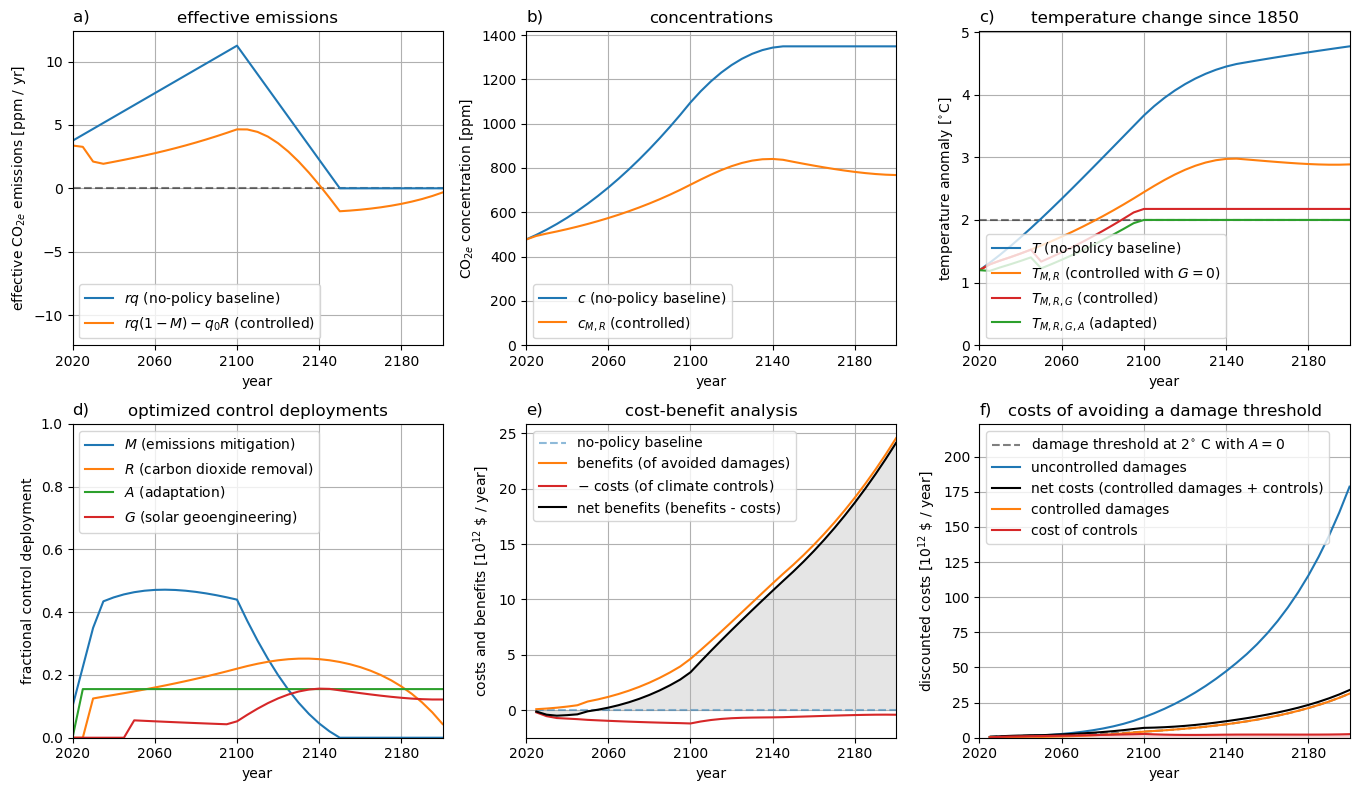

In [17]:
plot_state(model)